In [31]:
import h5py

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from glob import glob
from tabulate import tabulate

import sys
sys.path.insert(0, "../src")
from figures import figure_sizes, texp


def corrections_from_file(output_file, prior=False):
    """ Read in errors from output file. """
    checkpoint = h5py.File(output_file, "r")
    nu = checkpoint["/"].attrs["nu"]
    s = checkpoint["/"].attrs["s"]
    nx_obs = checkpoint["/"].attrs["nx_obs"]
    nt_skip = checkpoint["/"].attrs["nt_skip"]
    k = checkpoint["/"].attrs["k"]
    linear = checkpoint["/"].attrs["linear"]
    
    # just verify we are doing the correct thing
    assert checkpoint["/"].attrs["rho_h"] == 2e-3

    # HACK(connor): get analysis to work with failed times
    t_obs = checkpoint["/t_obs"][:]
    idx_failed = t_obs > 0

    t_obs = t_obs[idx_failed]
    u_correction = checkpoint["/u_correction"][idx_failed, :]
    h_correction = checkpoint["/h_correction"][idx_failed, :]
    x_grid = np.linspace(0, 10_000, h_correction.shape[1]) 

    # coordinates
    coords = dict(t=t_obs,
                  x=x_grid,
                  nu=np.array([nu]),
                  s=np.array([s]),
                  nx_obs=np.array([nx_obs]),
                  nt_skip=np.array([nt_skip]))

    # load in and return corrections
    return xr.Dataset(
        data_vars=dict(
            u_correction=(["t", "x", "s", "nu", "nx_obs", "nt_skip"], 
                          u_correction[:, :, np.newaxis, np.newaxis, np.newaxis, np.newaxis]),
            h_correction=(["t", "x", "s", "nu", "nx_obs", "nt_skip"], 
                          h_correction[:, :, np.newaxis, np.newaxis, np.newaxis, np.newaxis])),
        coords=coords)

def build_output_ds(output_files, prior=False):
    errors_ds = []
    for output_file in output_files:
        e = corrections_from_file(output_file)
        errors_ds.append(e)

    errors = xr.merge(errors_ds)
    return errors

In [32]:
corrections = build_output_ds(glob(
    "../outputs/swe-tidal-redo-sparse/nonlinear-posterior-*-nx_obs-1-nt_skip-30-*.h5"))
print(corrections)

<xarray.Dataset>
Dimensions:       (t: 1440, x: 501, nu: 5, s: 5, nx_obs: 1, nt_skip: 1)
Coordinates:
  * t             (t) float64 1.0 31.0 61.0 ... 4.311e+04 4.314e+04 4.317e+04
  * x             (x) float64 0.0 20.0 40.0 60.0 ... 9.96e+03 9.98e+03 1e+04
  * nu            (nu) float64 1.0 1e+03 1e+04 5e+04 1e+05
  * s             (s) float64 2e+03 3.5e+03 5e+03 6.5e+03 8e+03
  * nx_obs        (nx_obs) int64 1
  * nt_skip       (nt_skip) int64 30
Data variables:
    u_correction  (t, x, s, nu, nx_obs, nt_skip) float64 -4.012e-07 ... 1.138...
    h_correction  (t, x, s, nu, nx_obs, nt_skip) float64 -2.789e-06 ... -0.00...


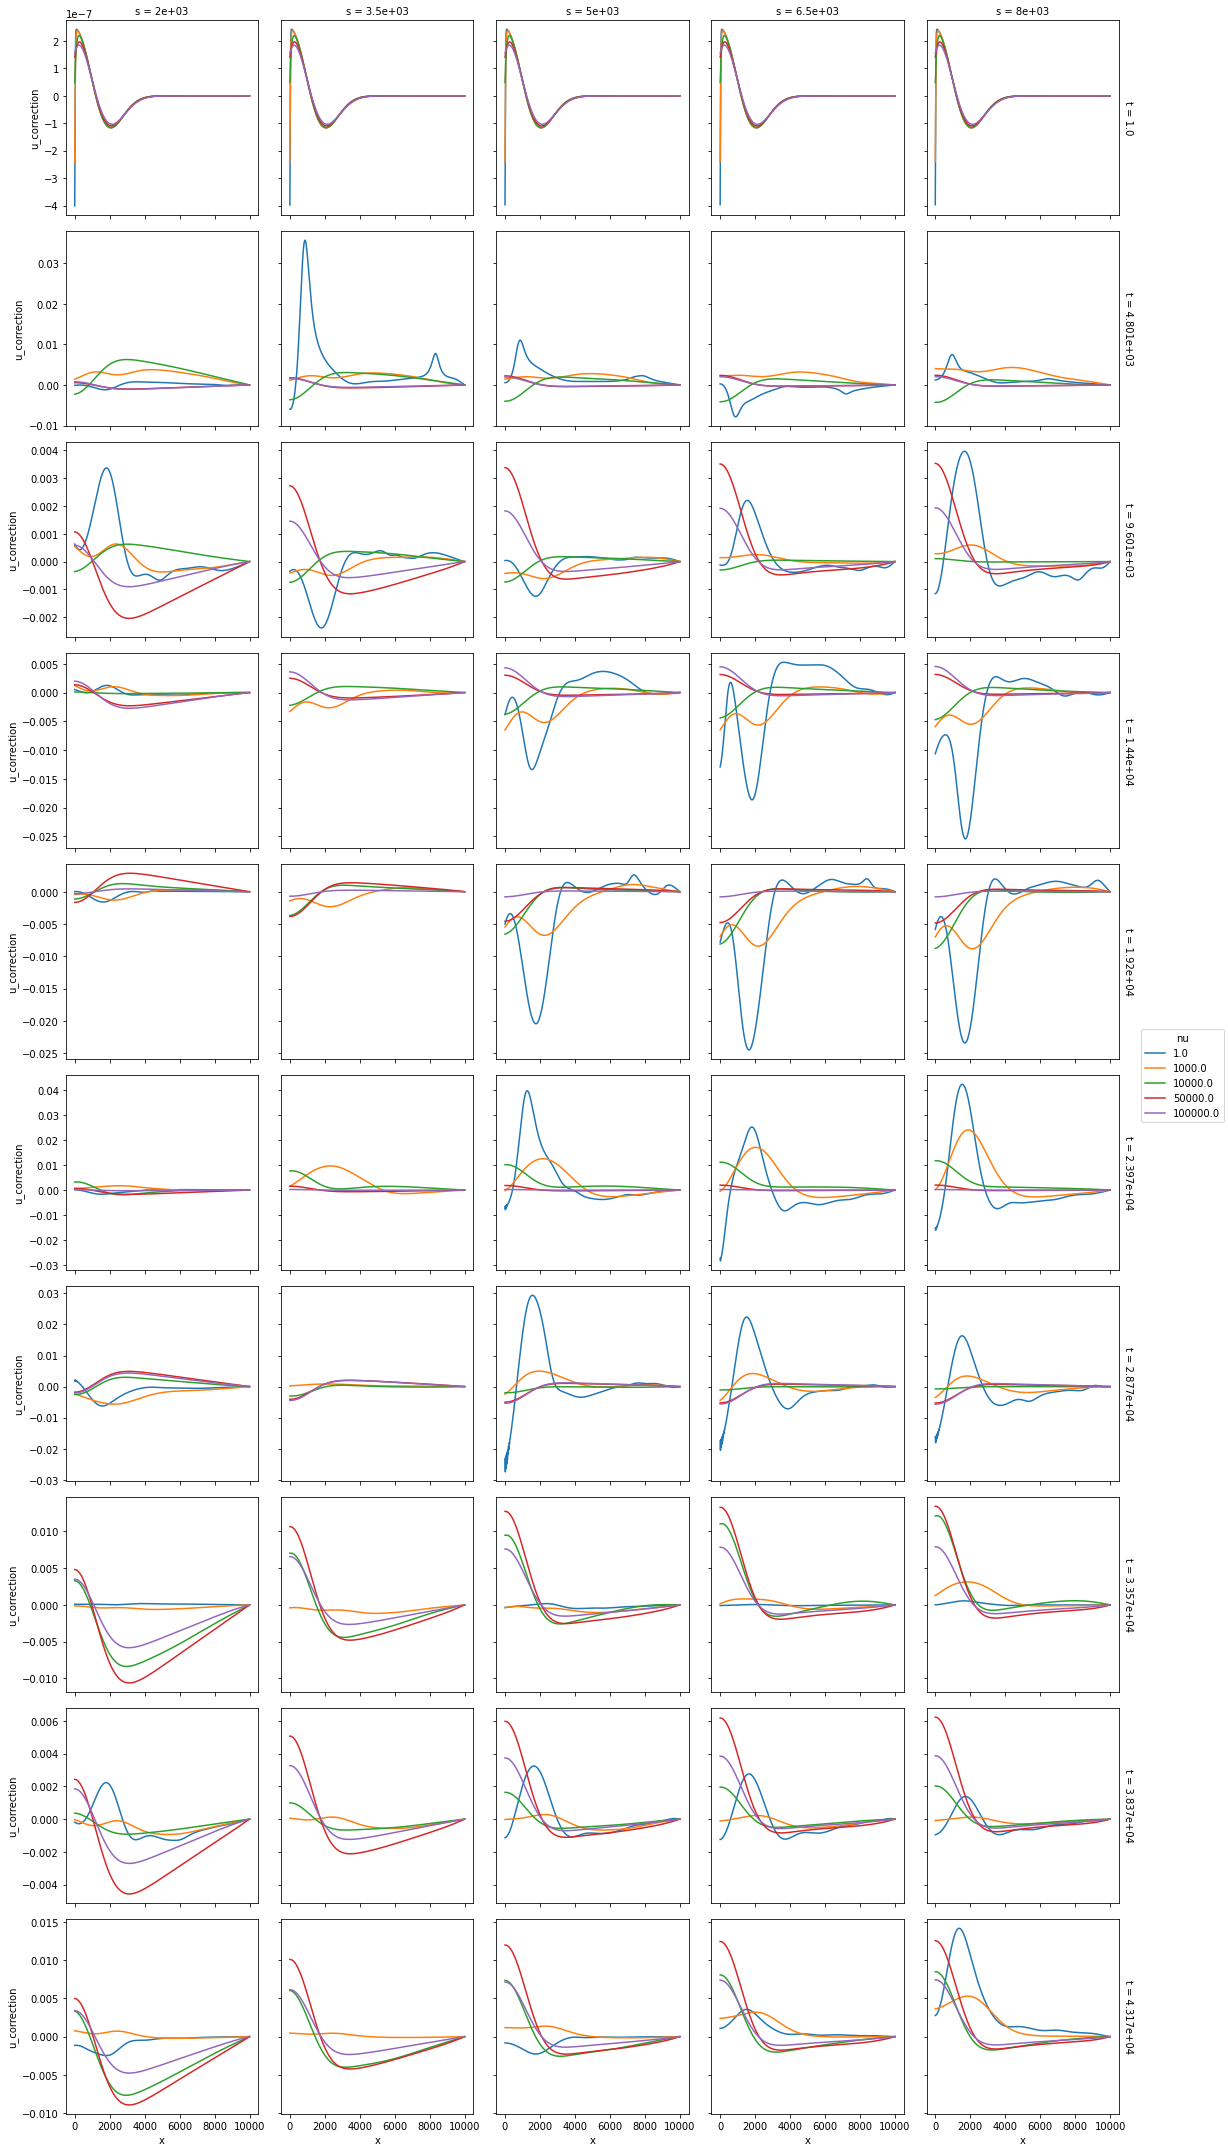

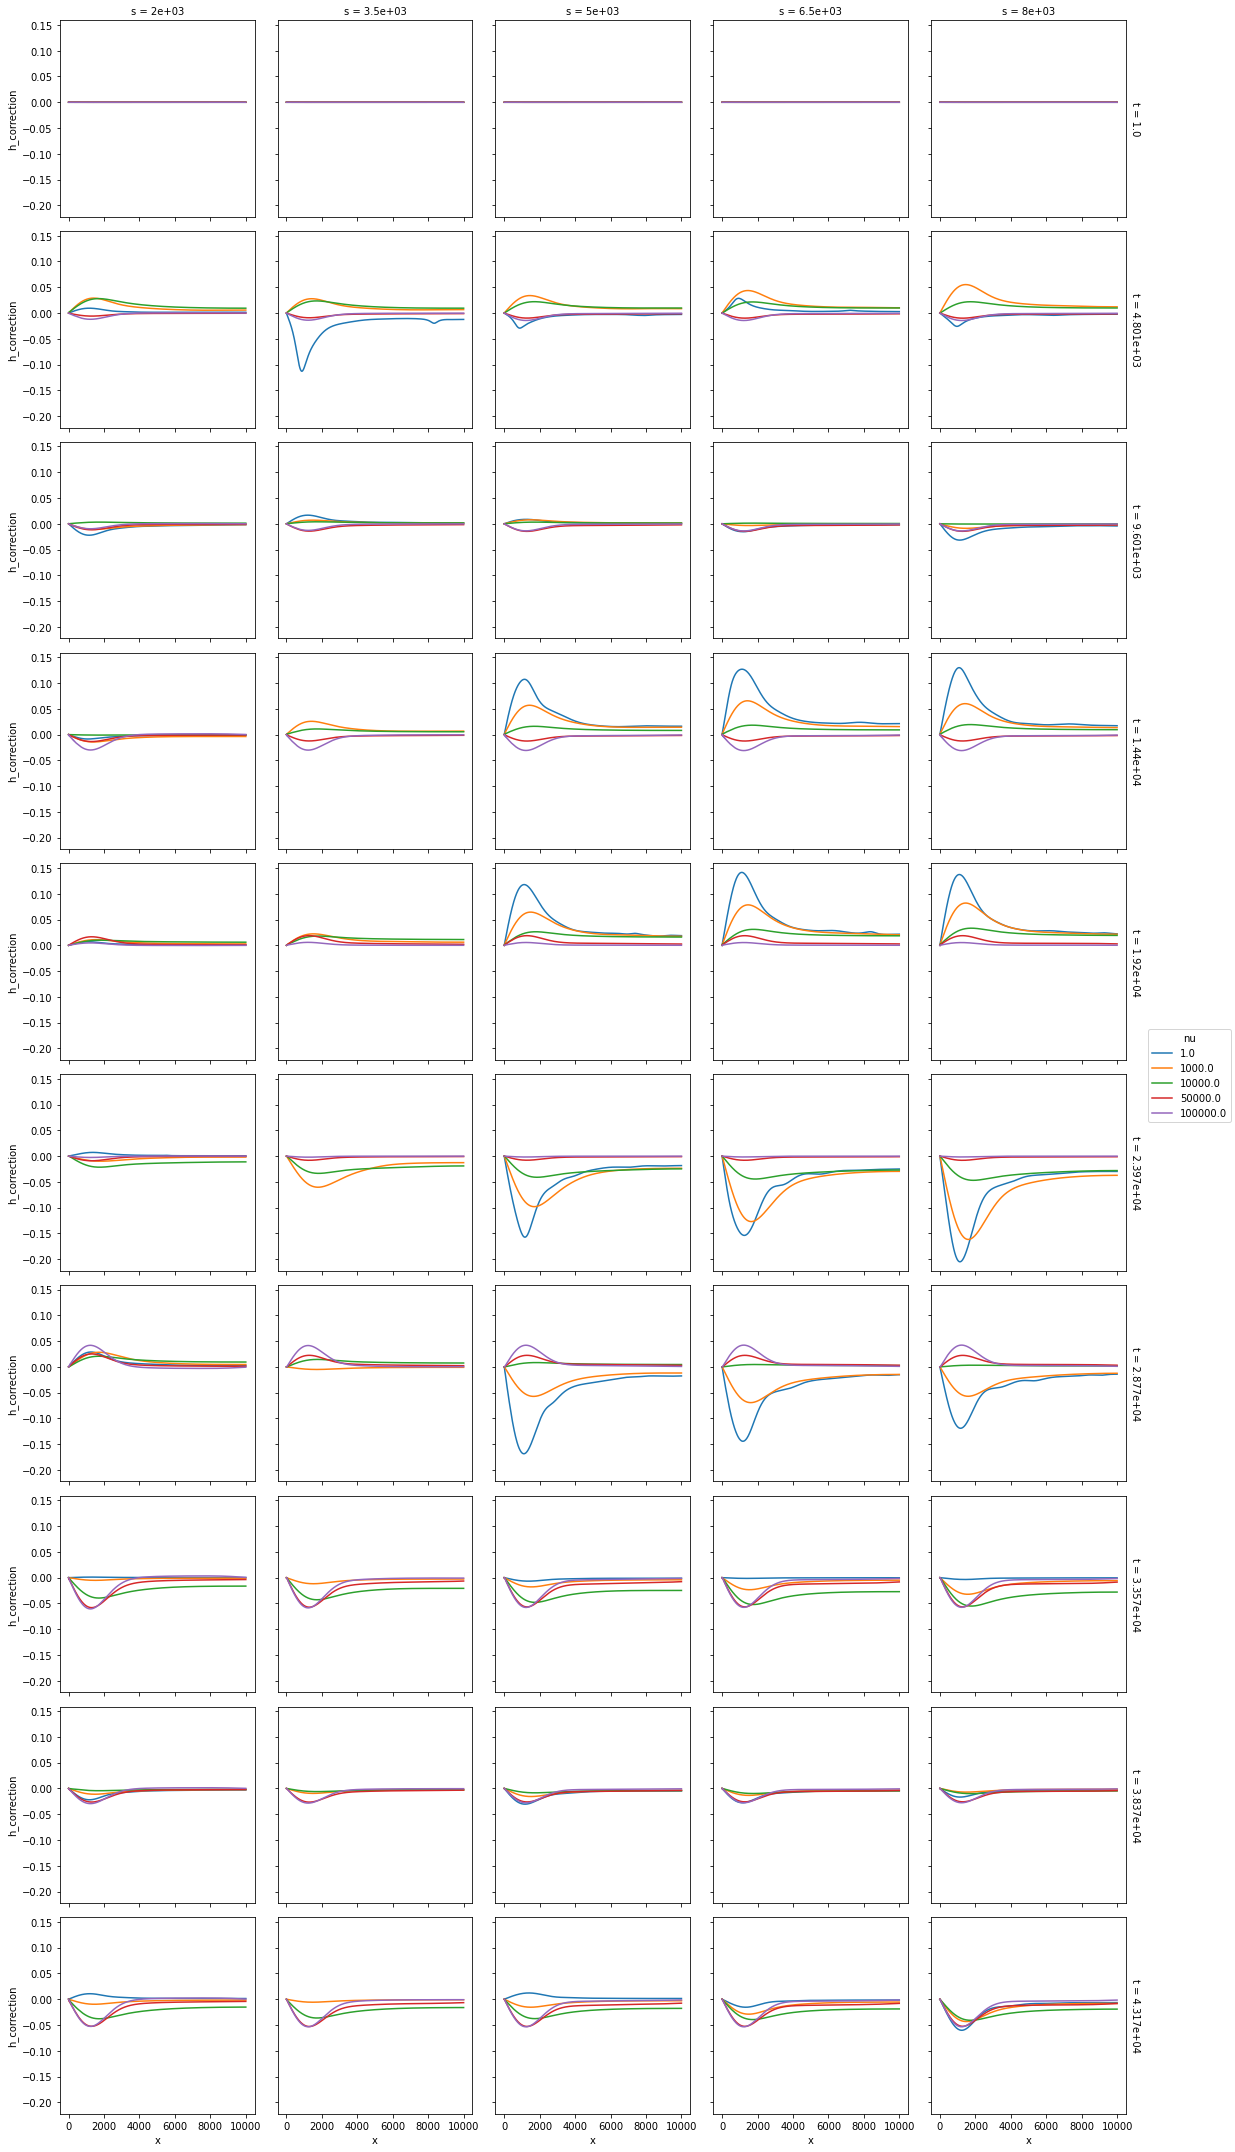

In [33]:
t_idx = np.int32(np.round(np.linspace(0, 1440 - 1, 10)))
corrections.isel(t=t_idx).u_correction.plot(row="t", col="s", hue="nu",
                                           sharey="row")
plt.show()

corrections.isel(t=t_idx).h_correction.plot(row="t", col="s", hue="nu")
plt.show()